## Data 

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [44]:
HURON_DATA = '../data/CSV/LakeHuron.csv'
df_huron = pd.read_csv(HURON_DATA, index_col=False)
df_huron.head()

,Unnamed: 0,time,value
0,1,1875,580.38
1,2,1876,581.86
2,3,1877,580.97
3,4,1878,580.80
4,5,1879,579.79


In [45]:
df_huron = df_huron[['time', 'value']]
df_huron['t'] = df_huron['time'] - 1874
df_huron['value'] = df_huron['value'] - 570 # this is done to conform with the textbook

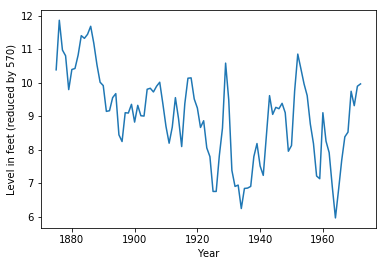

In [46]:
plt.xlabel('Year')
plt.ylabel('Level in feet (reduced by 570)')
plt.plot(df_huron.time, df_huron.value)

## Initial Model

Since the decrease in level seems to be approximately linear, the first model that was fitted was a simple regression model of the following form:

$$ Y_t = a_0 + a_1 t + \varepsilon_t,$$

where $\varepsilon_t$ represents noise; $t$ represents time with $1 \leq t \leq 98$.

In [47]:
df_huron.head(n=20)

,time,value,t
0,1875,10.38,1
1,1876,11.86,2
2,1877,10.97,3
3,1878,10.80,4
4,1879,9.79,5
5,1880,10.39,6
6,1881,10.42,7
7,1882,10.82,8
8,1883,11.40,9
9,1884,11.32,10


In [48]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)

t = df_huron[['t']]
Y = df_huron[['value']]

model.fit(t, Y)

a_0 = model.intercept_[0]
a_1 = model.coef_[0][0]

r2 = model.score(t, Y)

print('a_0 = {}; a_1 = {}'.format(a_0, a_1))
print('R2 score = {}'.format(r2))

a_0 = 10.202036608457815; a_1 = -0.024201110622318295
R2 score = 0.27247275621646183


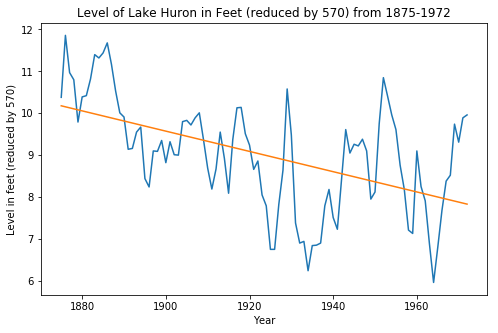

In [61]:
year = np.arange(1, 99, 1)
level = [a_0 + y * a_1 for y in year]

plt.figure(figsize=(8, 5))
plt.xlabel('Year')
plt.ylabel('Level in feet (reduced by 570)')
plt.title('Level of Lake Huron in Feet (reduced by 570) from 1875-1972')

plt.plot(df_huron.time, df_huron.value)
plt.plot(df_huron.time, level)

In [57]:
df_huron['residuals'] = df_huron['value'] - a_0 - a_1 * df_huron['t']

In [58]:
df_huron.head()

,time,value,t,residuals
0,1875,10.38,1,0.202165
1,1876,11.86,2,1.706366
2,1877,10.97,3,0.840567
3,1878,10.80,4,0.694768
4,1879,9.79,5,-0.291031


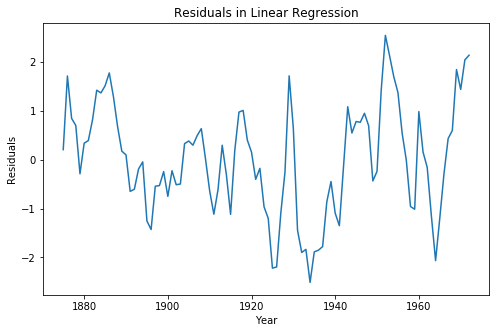

In [62]:
plt.figure(figsize=(8, 5))
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('Residuals in Linear Regression')

plt.plot(df_huron.time, df_huron.residuals)

## ACF of Residuals

In [66]:
def acf(ts, lag):
    n = len(ts)
    ts = np.asarray(ts)
    
    m = np.mean(ts)
    
    y1 = ts[ : n - lag]
    y2 = ts[lag : ]
    
    cov = np.sum((y1 - m) * (y2 - m)) 
    var = np.sum((ts - m)**2) 
    
    return cov / float(var)

def calculate_acfs(ts, max_lag):
    res = [(i, acf(ts, i)) for i in range(0, max_lag + 1)]
    return res

def plot_acf(ts, max_lag):
    points = calculate_acfs(ts, max_lag)
    
    #settings
    plt.figure(figsize=(10, 6.5))
    plt.ylim((-1.0, 1.0))
    plt.grid()
    
    # confidence limits
    cf = 1.96 / np.sqrt(len(ts))
    plt.axhline(y=cf, color='gray')
    plt.axhline(y=-cf, color='gray')
    plt.axhline(color='black')
    
    # labels
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.xticks(range(0, max_lag, 10))
    
    # actual plot
    lags = [l for (l, _) in points]
    acfs = [a for (_, a) in points]
    plt.stem(lags, acfs)
    
    plt.show()

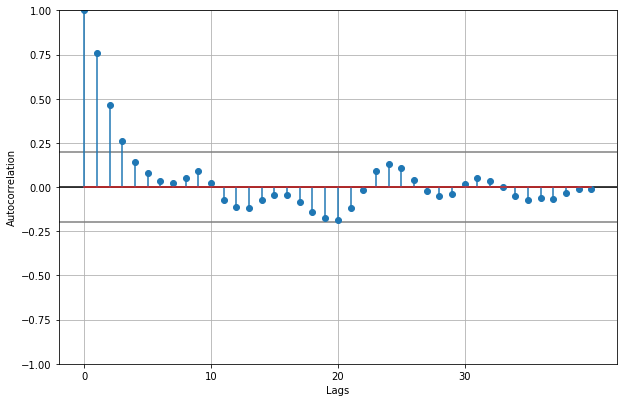

In [67]:
plot_acf(df_huron.residuals, max_lag=40)

### Interpreting the ACF of residuals plot

Had the residuals ${\varepsilon_1, \ldots, \varepsilon_{n}}$ been truly IID $N(0, \sigma^2)$, the ACFs $\hat{\rho}(h)$ for $0 < h < n$ would have been approximately IID $N(0, 1/n)$ (at least for large $n$). This, in turn, means that 95% of the ACF values should have been inside the $\pm 1.96 / \sqrt{n}$ lines of the graph above. Since three out of 40 ACF value lie outside, this suggests that the ACFs are probably not IID $N(0, 1/n)$. 

Also the first few ACF values show a roughly geometric progression and this suggests an AR$(1)$ model for the residuals. Such a model would look like so:
$$
    \varepsilon_t = \phi \varepsilon_{t - 1} + Z_t,
$$

where $Z_t$ is IID noise. Of course, it this model were to hold, the points $(\varepsilon_1, \varepsilon_2), \ldots, (\varepsilon_{n-1}, \varepsilon_n)$ would lie roughly on a straight line. This is what we check out next.

In [72]:
residuals = list(df_huron.residuals)

residuals_shifted = residuals[1: ]
residuals = residuals[ : -1]

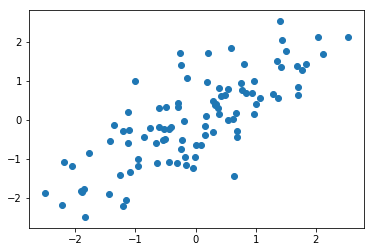

In [76]:
plt.scatter(residuals, residuals_shifted)
plt.show()

In [85]:
model = LinearRegression(fit_intercept=False)

model.fit(np.asarray(residuals).reshape(-1, 1), residuals_shifted)

a_1 = model.coef_[0]

print('a_1 = {}'.format(a_1))

a_1 = 0.7908423645936997


In [86]:
df_residuals = pd.DataFrame(columns=['res', 'res_shifted_1'])

df_residuals['res'] = residuals
df_residuals['res_shifted_1'] = residuals_shifted
df_residuals['estimate'] = a_1 * df_residuals['res']
df_residuals.head()

,res,res_shifted_1,estimate
0,0.202165,1.706366,0.159880
1,1.706366,0.840567,1.349466
2,0.840567,0.694768,0.664756
3,0.694768,-0.291031,0.549452
4,-0.291031,0.333170,-0.230160


In [87]:
df_residuals['residuals_of_residuals'] = df_residuals['res_shifted_1'] - df_residuals['estimate']

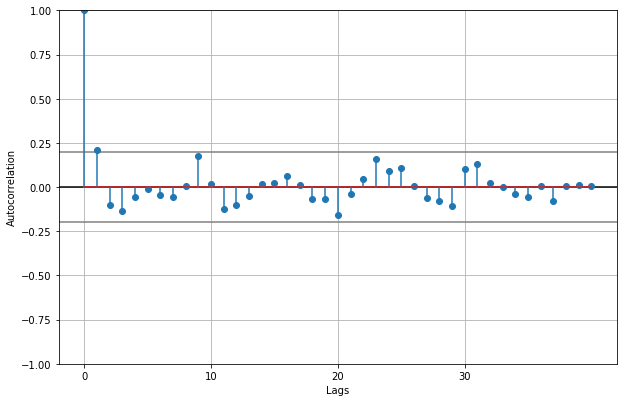

In [88]:
plot_acf(df_residuals.residuals_of_residuals, max_lag=40)

The sample ACF of the estimated noise sequence is slightly outside the bounds $\pm 1.96/97$ at lag 1, but it is inside the bounds for all other lags up to 40. This check that the estimated noise sequence is consistent with
the iid assumption and reinforces our belief in the fitted model.

A better fit to the residuals is provided by the second-order autoregressive model:
$$
        \varepsilon_t = \phi_1 \varepsilon_{t - 1} + \phi_2 \varepsilon_{t - 2} + Z_t,
$$
where $Z_t$ is IID noise.

In [89]:
residuals = list(df_huron.residuals)

residuals_shifted_1 = residuals[1: ]
residuals_shifted_2 = residuals[2: ]

residuals = residuals[:-2]
residuals_shifted_1 = residuals_shifted_1[: -1]

print(len(residuals), len(residuals_shifted_1), len(residuals_shifted_2))

96 96 96


In [91]:
df_ar_2 = pd.DataFrame(columns=['residuals', 'residuals_shft_1', 'residuals_shft_2'])
df_ar_2['residuals'] = residuals
df_ar_2['residuals_shft_1'] = residuals_shifted_1
df_ar_2['residuals_shft_2'] = residuals_shifted_2

model = LinearRegression(fit_intercept=False)

model.fit(df_ar_2[['residuals', 'residuals_shft_1']], df_ar_2.residuals_shft_2)

a_1 = model.coef_

print(a_1)

[-0.28339451  1.00198748]


In [92]:
df_ar_2['error'] = df_ar_2.residuals_shft_2 - a_1[0] * df_ar_2.residuals - a_1[1] * df_ar_2.residuals_shft_1

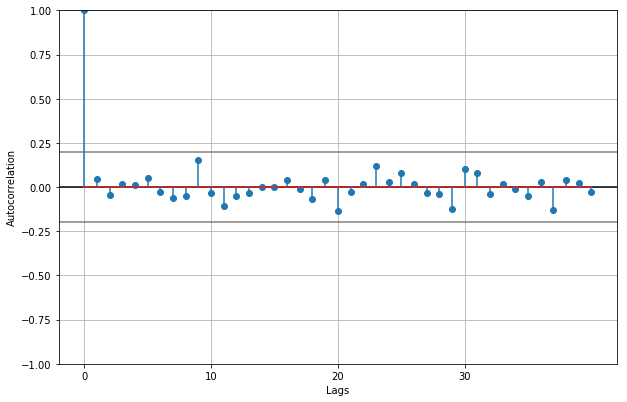

In [93]:
plot_acf(df_ar_2.error, max_lag=40)